# Lecture 12: Hypothesis Testing with Permutation Tests

## ENGR 10200 - A Data Science and Statistical Approach to Programming
**Instructor:** Michael Grossberg

---

In this notebook, we'll learn how to use **permutation testing** to determine whether differences between groups are statistically significant. We'll work through real examples step-by-step.

## Part 1: A Simple Example - Is This Coin Fair?

Suppose you flip a coin 100 times and get 60 heads. Is the coin fair?

**Null Hypothesis (H₀):** The coin is fair (probability of heads = 0.5)

**Alternative Hypothesis (H₁):** The coin is NOT fair

We can test this by simulating what we'd expect from a fair coin.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Set random seed for reproducibility
np.random.seed(42)

# Our observation
observed_heads = 60
n_flips = 100

print(f"Observed: {observed_heads} heads out of {n_flips} flips")
print(f"Expected (if fair): {n_flips * 0.5} heads")
print(f"\nDifference: {observed_heads - n_flips * 0.5} heads")

Observed: 60 heads out of 100 flips
Expected (if fair): 50.0 heads

Difference: 10.0 heads


Now let's simulate 10,000 trials of flipping a fair coin 100 times:

In [ ]:
# Number of coin flips per simulation
n_flips = 100
# Number of simulations
n_simulations = 10000

# Simulate fair coin flips using 0 (tails) and 1 (heads)
# Each row is one simulation (100 flips)
flips = np.random.randint(0, 2, size=(n_simulations, n_flips))

# Sum across rows to count heads per simulation
simulated_heads = flips.sum(axis=1)

print(f"Simulated {n_simulations} trials of {n_flips} coin flips")
print(f"Mean heads: {simulated_heads.mean():.1f}")
print(f"Std dev: {simulated_heads.std():.1f}")

# Observed number of heads (for example 60 out of 100)
observed_heads = 60

# Calculate p-value: how often do we see 60 or more heads?
p_value = np.sum(simulated_heads >= observed_heads) / n_simulations
print(f"\nP-value (one-sided): {p_value:.4f}")
print(f"This means {p_value*100:.2f}% of fair coins give 60+ heads in 100 flips")

Simulated 10000 trials of 100 coin flips
Mean heads: 50.1
Std dev: 5.0

P-value (one-sided): 0.0301
This means 3.01% of fair coins give 60+ heads in 100 flips


Visualize the distribution:

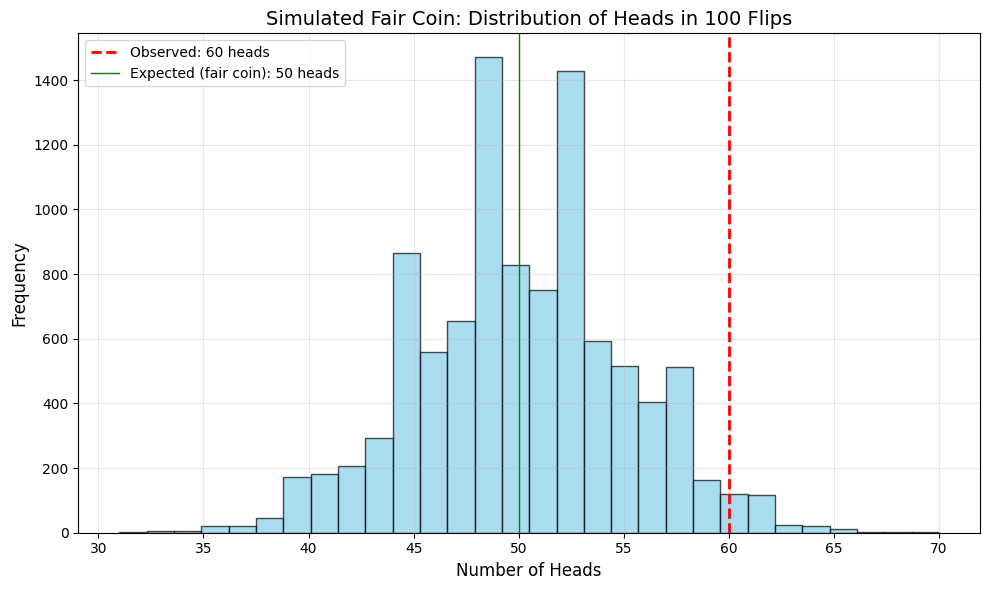


✓ Result: REJECT null hypothesis (coin appears unfair)


In [3]:
# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(simulated_heads, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
plt.axvline(observed_heads, color='red', linestyle='--', linewidth=2,
            label=f'Observed: {observed_heads} heads')
plt.axvline(50, color='green', linestyle='-', linewidth=1,
            label='Expected (fair coin): 50 heads')
plt.xlabel('Number of Heads', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Simulated Fair Coin: Distribution of Heads in 100 Flips', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

if p_value < 0.05:
    print("\n✓ Result: REJECT null hypothesis (coin appears unfair)")
else:
    print("\n✗ Result: FAIL TO REJECT null hypothesis (consistent with fair coin)")

## Part 2: Birth Weight and Maternal Smoking

Now we'll work with a real dataset to answer an important medical question:

**Research Question:** Does maternal smoking affect birth weight?

### The Dataset
This is data from 1,174 births. For each birth, we have:
- Birth weight (in ounces)
- Whether the mother smoked during pregnancy

Let's load and explore the data:

In [4]:
import pandas as pd

# Load the baby dataset
baby = pd.read_csv('https://raw.githubusercontent.com/data-8/textbook/main/assets/data/baby.csv')

print("Birth Weight Dataset")
print("="*60)
print(f"Number of births: {len(baby)}")
print(f"\nFirst 10 rows:")
print(baby.head(10))
print(f"\nColumn names:")
print(baby.columns.tolist())

Birth Weight Dataset
Number of births: 1174

First 10 rows:
   Birth Weight  Gestational Days  Maternal Age  Maternal Height  \
0           120               284            27               62   
1           113               282            33               64   
2           128               279            28               64   
3           108               282            23               67   
4           136               286            25               62   
5           138               244            33               62   
6           132               245            23               65   
7           120               289            25               62   
8           143               299            30               66   
9           140               351            27               68   

   Maternal Pregnancy Weight  Maternal Smoker  
0                        100            False  
1                        135            False  
2                        115             True  

### Exploratory Data Analysis

Before any statistical test, we should **always** explore the data first.

In [5]:
# How many smokers vs non-smokers?
print("Maternal Smoking Status:")
print(baby['Maternal Smoker'].value_counts())
print(f"\nPercentage who smoked: {baby['Maternal Smoker'].sum() / len(baby) * 100:.1f}%")

Maternal Smoking Status:
Maternal Smoker
False    715
True     459
Name: count, dtype: int64

Percentage who smoked: 39.1%


Now let's compare birth weights between the two groups:

In [6]:
# Summary statistics by group
print("Birth Weight Summary by Smoking Status")
print("="*60)
summary = baby.groupby('Maternal Smoker')['Birth Weight'].describe()
print(summary)

# Calculate means for each group
nonsmoker_weights = baby[baby['Maternal Smoker'] == False]['Birth Weight']
smoker_weights = baby[baby['Maternal Smoker'] == True]['Birth Weight']

mean_nonsmoker = nonsmoker_weights.mean()
mean_smoker = smoker_weights.mean()

print(f"\nMean birth weight (Non-smokers): {mean_nonsmoker:.2f} oz")
print(f"Mean birth weight (Smokers):     {mean_smoker:.2f} oz")
print(f"\nObserved difference: {mean_nonsmoker - mean_smoker:.2f} oz")
print("(Positive means non-smokers have heavier babies)")

Birth Weight Summary by Smoking Status
                 count        mean        std   min    25%    50%    75%  \
Maternal Smoker                                                            
False            715.0  123.085315  17.423695  55.0  113.0  123.0  134.0   
True             459.0  113.819172  18.295010  58.0  101.0  115.0  126.0   

                   max  
Maternal Smoker         
False            176.0  
True             163.0  

Mean birth weight (Non-smokers): 123.09 oz
Mean birth weight (Smokers):     113.82 oz

Observed difference: 9.27 oz
(Positive means non-smokers have heavier babies)


Let's visualize this difference:

<Figure size 1000x600 with 0 Axes>

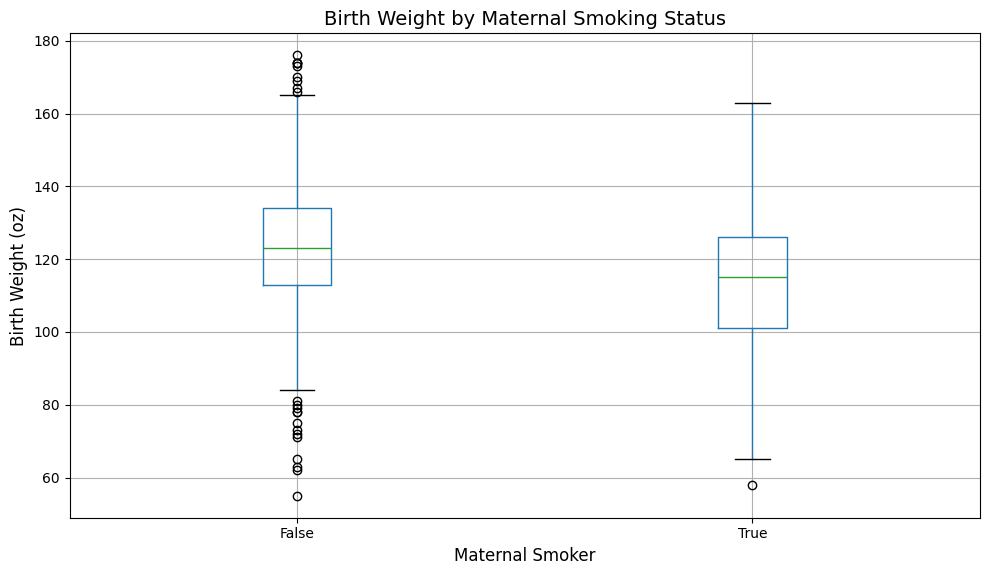

Visual observation: Smokers appear to have lighter babies on average.
But is this difference statistically significant?


In [7]:
# Box plot comparison
plt.figure(figsize=(10, 6))
baby.boxplot(column='Birth Weight', by='Maternal Smoker', figsize=(10, 6))
plt.suptitle('')  # Remove default title
plt.title('Birth Weight by Maternal Smoking Status', fontsize=14)
plt.xlabel('Maternal Smoker', fontsize=12)
plt.ylabel('Birth Weight (oz)', fontsize=12)
plt.tight_layout()
plt.show()

print("Visual observation: Smokers appear to have lighter babies on average.")
print("But is this difference statistically significant?")

## Part 3: Testing the Hypothesis with Permutation

**Null Hypothesis (H₀):** Maternal smoking has NO effect on birth weight.
- The difference we see is just random chance.
- The labels "smoker" and "non-smoker" are arbitrary.

**Alternative Hypothesis (H₁):** Maternal smoking DOES affect birth weight.

### The Permutation Test Idea

If H₀ is true (smoking doesn't matter), then:
- We could randomly shuffle the "Maternal Smoker" labels
- The difference in means shouldn't change much
- Our observed difference should be typical of random shuffles

If H₀ is false (smoking matters), then:
- Random shuffles will usually give smaller differences
- Our observed difference will be unusual (in the tail of the distribution)

Let's implement this step-by-step!

### Step 1: Calculate the Observed Test Statistic

We'll use **difference in group means** as our test statistic.

Let δ_μ (delta mu) = mean(non-smoker) - mean(smoker)

In [8]:
# Step 1: Calculate observed difference
observed_delta_mu = mean_nonsmoker - mean_smoker

print("STEP 1: Observed Test Statistic")
print("="*60)
print(f"δ_μ (delta mu) = {observed_delta_mu:.3f} oz")
print(f"\nThis is the difference we need to evaluate.")
print(f"Is {observed_delta_mu:.3f} oz surprisingly large, or could it happen by chance?")

STEP 1: Observed Test Statistic
δ_μ (delta mu) = 9.266 oz

This is the difference we need to evaluate.
Is 9.266 oz surprisingly large, or could it happen by chance?


### Step 2: Permute the Labels

Now we'll shuffle the "Maternal Smoker" labels randomly while keeping the birth weights in place.

**Key point:** We're breaking the association between smoking status and birth weight.

In [9]:
# Step 2: One permutation example
print("STEP 2: Example of One Permutation")
print("="*60)

# Make a copy and shuffle the Maternal Smoker column
baby_permuted = baby.copy()
baby_permuted['Maternal Smoker'] = np.random.permutation(baby['Maternal Smoker'].values)

print("Original data (first 10 rows):")
print(baby[['Birth Weight', 'Maternal Smoker']].head(10))
print("\nAfter permutation (first 10 rows):")
print(baby_permuted[['Birth Weight', 'Maternal Smoker']].head(10))
print("\nNotice: Birth weights stay the same, but smoker labels are shuffled!")

STEP 2: Example of One Permutation
Original data (first 10 rows):
   Birth Weight  Maternal Smoker
0           120            False
1           113            False
2           128             True
3           108             True
4           136            False
5           138            False
6           132            False
7           120            False
8           143             True
9           140            False

After permutation (first 10 rows):
   Birth Weight  Maternal Smoker
0           120             True
1           113             True
2           128            False
3           108            False
4           136            False
5           138            False
6           132            False
7           120            False
8           143            False
9           140            False

Notice: Birth weights stay the same, but smoker labels are shuffled!


Now calculate the difference in means for this permuted dataset:

In [10]:
# Calculate difference for this one permutation
perm_nonsmoker = baby_permuted[baby_permuted['Maternal Smoker'] == False]['Birth Weight']
perm_smoker = baby_permuted[baby_permuted['Maternal Smoker'] == True]['Birth Weight']
perm_delta_mu = perm_nonsmoker.mean() - perm_smoker.mean()

print(f"Observed δ_μ:  {observed_delta_mu:.3f} oz")
print(f"Permuted δ_μ:  {perm_delta_mu:.3f} oz")
print(f"\nThe permuted difference is different because the labels were shuffled!")

Observed δ_μ:  9.266 oz
Permuted δ_μ:  -0.378 oz

The permuted difference is different because the labels were shuffled!


### Step 3: Repeat Many Times (1000 Permutations)

We'll do 1000 permutations to build a **null distribution** of what differences we'd expect by chance.

In [11]:
# Step 3: Perform 1000 permutations
print("STEP 3: Running 1000 Permutations")
print("="*60)

n_permutations = 1000
permuted_differences = []

# Get the original arrays
birth_weights = baby['Birth Weight'].values
smoker_labels = baby['Maternal Smoker'].values

for i in range(n_permutations):
    # Shuffle the labels (without shuffling the birth weights!)
    shuffled_labels = np.random.permutation(smoker_labels)

    # Calculate means for shuffled groups
    nonsmoker_mean = birth_weights[shuffled_labels == False].mean()
    smoker_mean = birth_weights[shuffled_labels == True].mean()

    # Calculate and store the difference
    diff = nonsmoker_mean - smoker_mean
    permuted_differences.append(diff)

# Convert to numpy array
permuted_differences = np.array(permuted_differences)

print(f"✓ Completed {n_permutations} permutations")
print(f"\nPermuted differences statistics:")
print(f"  Mean:   {permuted_differences.mean():.3f} oz")
print(f"  Std:    {permuted_differences.std():.3f} oz")
print(f"  Min:    {permuted_differences.min():.3f} oz")
print(f"  Max:    {permuted_differences.max():.3f} oz")

STEP 3: Running 1000 Permutations
✓ Completed 1000 permutations

Permuted differences statistics:
  Mean:   0.058 oz
  Std:    1.072 oz
  Min:    -3.379 oz
  Max:    3.006 oz


### Step 4: Visualize the Null Distribution

Let's plot the histogram of permuted differences and see where our observed difference falls.

The **red line** shows the observed difference from the actual data.

STEP 4: Visualizing the Null Distribution


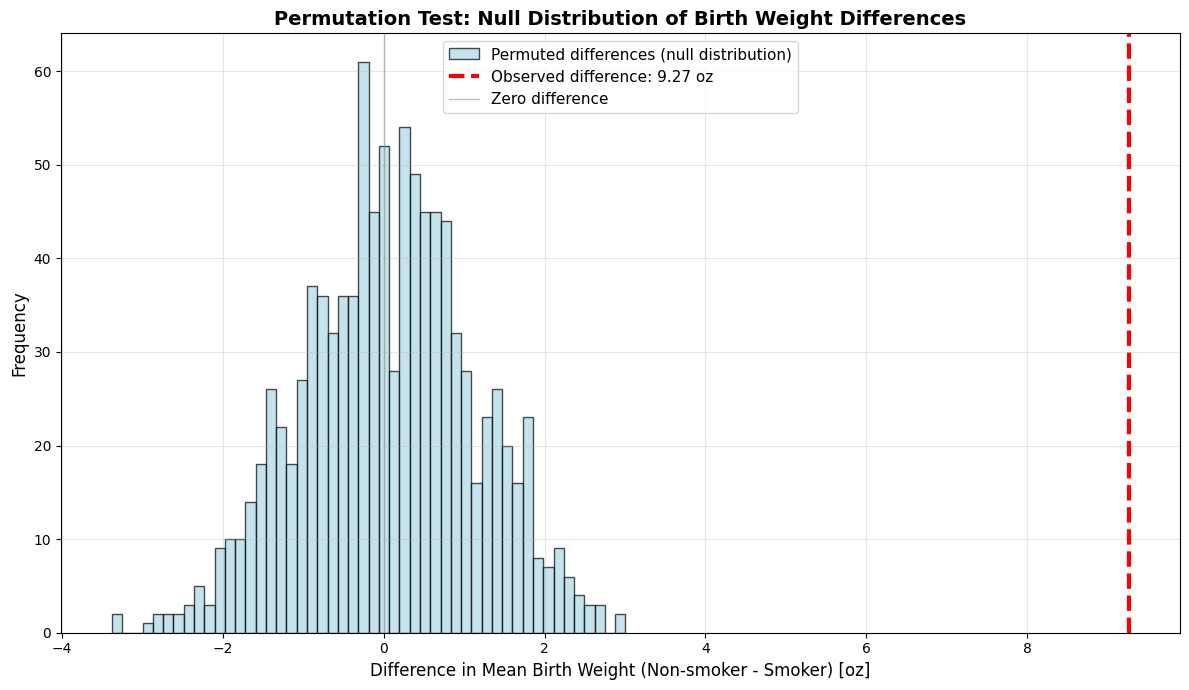


📊 The RED LINE is our observed difference from the real data.
📊 The HISTOGRAM shows what we'd expect if smoking had NO effect.

Notice how far the red line is from the center of the distribution!


In [12]:
# Step 4: Visualize
print("STEP 4: Visualizing the Null Distribution")
print("="*60)

plt.figure(figsize=(12, 7))
plt.hist(permuted_differences, bins=50, alpha=0.7, color='lightblue',
         edgecolor='black', label='Permuted differences (null distribution)')
plt.axvline(observed_delta_mu, color='red', linestyle='--', linewidth=3,
            label=f'Observed difference: {observed_delta_mu:.2f} oz')
plt.axvline(0, color='gray', linestyle='-', linewidth=1, alpha=0.5,
            label='Zero difference')

plt.xlabel('Difference in Mean Birth Weight (Non-smoker - Smoker) [oz]', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Permutation Test: Null Distribution of Birth Weight Differences',
          fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\n📊 The RED LINE is our observed difference from the real data.")
print("📊 The HISTOGRAM shows what we'd expect if smoking had NO effect.")
print("\nNotice how far the red line is from the center of the distribution!")

### Step 5: Calculate the P-Value

The p-value answers: **"If smoking had no effect, what's the probability of seeing a difference as large as (or larger than) what we observed?"**

We count how many permuted differences are **greater than or equal to** our observed difference.

In [ ]:
# Step 5: Calculate p-value
print("STEP 5: Calculate P-Value")
print("="*60)

# Count how many permuted differences are >= observed
num_extreme = np.sum(permuted_differences >= observed_delta_mu)
p_value = num_extreme / n_permutations

print(f"Observed difference:      {observed_delta_mu:.3f} oz")
print(f"Number of permutations:   {n_permutations}")
print(f"Permutations >= observed: {num_extreme}")
print(f"\nP-value = {num_extreme}/{n_permutations} = {p_value:.4f}")
print(f"\n📌 Interpretation:")
print(f"   If smoking had NO effect, we'd see a difference this large")
print(f"   or larger in 5% of random shuffles.")

STEP 5: Calculate P-Value
Observed difference:      9.266 oz
Number of permutations:   1000
Permutations >= observed: 0

P-value = 0/1000 = 0.0000

📌 Interpretation:
   If smoking had NO effect, we'd see a difference this large
   or larger in 0.00% of random shuffles.


### Step 6: Make a Decision

Standard significance level: **α = 0.05** (5%)

**Decision Rule:**
- If p-value < 0.05: **Reject H₀** (evidence that smoking affects birth weight)
- If p-value ≥ 0.05: **Fail to reject H₀** (insufficient evidence)

In [14]:
# Step 6: Decision
print("STEP 6: Statistical Decision")
print("="*60)
print(f"Significance level (α): 0.05")
print(f"P-value: {p_value:.4f}")
print(f"\n{'='*60}")

if p_value < 0.05:
    print("✓ DECISION: REJECT the null hypothesis")
    print("="*60)
    print("\nCONCLUSION:")
    print("  There IS statistically significant evidence that maternal")
    print("  smoking affects birth weight.")
    print(f"\n  Babies born to smokers are on average {observed_delta_mu:.2f} oz")
    print("  lighter than babies born to non-smokers.")
    print(f"\n  This difference is unlikely to be due to chance alone")
    print(f"  (p = {p_value:.4f} < 0.05).")
else:
    print("✗ DECISION: FAIL TO REJECT the null hypothesis")
    print("="*60)
    print("\nCONCLUSION:")
    print("  There is NOT sufficient evidence that maternal smoking")
    print("  affects birth weight.")
    print(f"\n  The observed difference of {observed_delta_mu:.2f} oz could")
    print(f"  reasonably occur by chance (p = {p_value:.4f} >= 0.05).")

print(f"\n{'='*60}")

STEP 6: Statistical Decision
Significance level (α): 0.05
P-value: 0.0000

✓ DECISION: REJECT the null hypothesis

CONCLUSION:
  There IS statistically significant evidence that maternal
  smoking affects birth weight.

  Babies born to smokers are on average 9.27 oz
  lighter than babies born to non-smokers.

  This difference is unlikely to be due to chance alone
  (p = 0.0000 < 0.05).



## Summary: The Permutation Test Process

### What We Did:

1. **Stated our hypotheses**
   - H₀: Smoking has no effect on birth weight
   - H₁: Smoking affects birth weight

2. **Chose a test statistic**
   - δ_μ = difference in mean birth weights (non-smoker - smoker)

3. **Calculated observed statistic**
   - From real data: computed δ_μ for the actual groups

4. **Simulated under the null hypothesis**
   - Randomly shuffled smoking labels 1000 times
   - **Kept birth weights in their original positions**
   - Calculated δ_μ for each shuffle
   - Built a distribution of what we'd expect by chance

5. **Calculated p-value**
   - Counted how often random shuffles give differences ≥ observed
   - p = (number of extreme values) / (total permutations)

6. **Made a decision**
   - Compared p-value to α = 0.05
   - Rejected or failed to reject H₀

### Key Insights:

✓ **Permutation tests are powerful** - No assumptions about distributions needed!

✓ **"Let the computer do the work"** - We don't need complex formulas

✓ **Visualization is crucial** - Always plot the null distribution

✓ **P-values have a precise meaning** - Probability of seeing our result (or more extreme) if H₀ is true

✓ **Labels are shuffled, data stays in place** - This is the key to permutation testing!

### References:
- Dataset from UC Berkeley Data 8 course
- Permutation test method from Jake VanderPlas, "Statistics for Hackers"


## Practice Exercise

Try modifying the code above to:

1. **Use a different test statistic**
   - Try median instead of mean
   - Try the difference in standard deviations
   - What happens to the p-value?

2. **Test a different variable**
   - Does smoking affect gestational days?
   - Does maternal age affect birth weight?

3. **Change the number of permutations**
   - Try 100, 500, 5000, 10000
   - How stable is the p-value?

4. **Change the significance level**
   - Try α = 0.01 (more stringent)
   - Try α = 0.10 (less stringent)
   - How does this change your conclusion?

5. **Investigate the effect size**
   - Convert the difference from ounces to grams (1 oz ≈ 28.35 g)
   - Is this clinically significant?
